***
# WorldQuant University
<b>MScFE 610 Econometrics: Group Project 1 Submission</b><br>
***

<b>Group 11 Team Members:</b>

- Beh Min Yan
- Mohammadkian Maghsoodi
- Rahul Patil

# Question 6

<b>This notebook contains our worked solutions to Q6, including code, outputs, and short answers as to the interpretation of results.</b>

***

**Import Libraries and Relevant Datasets**

In [1]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings('ignore')

# Import datasets calculated in Question 3
gold_etf_df = pd.read_csv('gold.csv').set_index('Date')
equity_etf_df = pd.read_csv('equity.csv').set_index('Date')

**Calculate log returns**

In [2]:
gold_etf_df['log_returns'] = np.log(gold_etf_df['Adj Close'] / gold_etf_df['Open'])
equity_etf_df['log_returns'] = np.log(equity_etf_df['Adj Close'] / equity_etf_df['Open'])

**Split all datasets into October and November 2019 datasets**

In [3]:
gold_oct_df = gold_etf_df[:'2019-10-31']
gold_nov_df = gold_etf_df['2019-11-01':]

eq_oct_df = equity_etf_df[:'2019-10-31']
eq_nov_df = equity_etf_df['2019-11-01':]

# 6 Modelling Prices

<div class="alert alert-block alert-info">

For finding appropriate "p" and "q" values for the ARMA model we have two main ways:<br/>
    
(1) Use PACF chart of the series for finding the "p" parameter of the AR chunk of our ARMA, and utilise ACF for finding the "q" value for the MA part. This method, despite its dependence on analyst's judgment and subsequent subjectivity, had been the industry's first-go-to method for many years. <br/>
    
(2) The second method, and more robust one, is using Python's <code>pmdarima</code> library to carry out a systematic grid search of ARMA's parameters based on Akaike Information Criteria. For sake of demonstration we find "p" and "q" parameters for Gold ETF's October data using both of these methods, but for the rest we will stick to <code>pmdarima</code>'s grid search. <br/><br/>


For each piece of price data, before running any analysis, an ADF (Augmented Dickey-Fuller test) is carried out to confirm that our data is stationary for fitting an ARMA model, if its not stationary, then we continue taking the difference of price with its lag, until the series is stationary. <br/><br/>

The significance interval for the ADF test is 5%.
</div>    


<b>6.1) Using the October gold ETF prices, run an ARIMA model with your choice of parameters.</b>

In [4]:
# We first perform the Augmented Dickey-Fuller test to confirm that our data is stationary for fitting the ARMA model.

def get_stationary_series(df, col='Adj Close'):
    p_value_adf = adfuller(df[col])[1]
    stationarity = p_value_adf < 0.05
    print(f"The series is {'' if stationarity else 'not '}stationary.")
    series = df[col]
    differentiation_factor = 0

    while not stationarity:
        series = (series - series.shift(1)).dropna()
        differentiation_factor += 1
        p_value_adf = adfuller(series)[1]
        if p_value_adf < 0.05:
            stationarity = True
    print("We have done {} iterations of differentiations.".format(differentiation_factor))
    return series

The series is not stationary.
We have done 2 iterations of differentiations.


Date
2019-10-03   -0.989990
2019-10-04   -0.639999
2019-10-07   -1.209991
2019-10-08    2.439987
2019-10-09   -1.099991
2019-10-10   -1.370010
2019-10-11    0.460007
2019-10-14    1.339996
2019-10-15   -1.539993
2019-10-16    1.779999
2019-10-17   -0.600006
2019-10-18   -0.349991
2019-10-21   -0.520020
2019-10-22    1.080017
2019-10-23   -0.080002
2019-10-24    0.669998
2019-10-25   -0.669998
2019-10-28   -1.550003
2019-10-29    0.830002
2019-10-30    1.160004
2019-10-31    0.639984
Name: Adj Close, dtype: float64

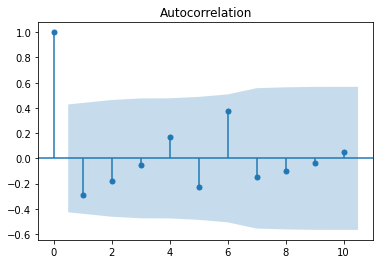

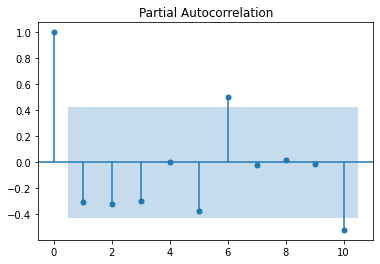

In [5]:
# Calculate stationary series from dataset
gold_oct_stationary_series = get_stationary_series(gold_oct_df)

# Plot the charts
plot_acf(gold_oct_stationary_series, lags = 10)
plot_pacf(gold_oct_stationary_series, lags = 10)
gold_oct_stationary_series

<div class="alert alert-block alert-info">

<b>Interpretation of the charts:</b><br/>
As we can see there is a gradual decline in the ACF chart after the "first" lag, therefore, the appropriate value for MA part of our ARMA, namely the "q" value would be 1.<br/>

But there is no clear pattern of decline in the PACF chart, therefore, this diagnostic measure is inconclusive and we may want to find the value of p for the AR part of our ARMA model by employing a grid search scheme.<br/>
</div>

In [6]:
auto_arima(gold_oct_stationary_series, stationary=True, start_p=1, max_p = 10, 
           start_q = 1, max_q = 10, seasonal = False, trace= True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=68.958, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=69.079, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=66.960, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.214 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

<div class="alert alert-block alert-success">

<b>Interpretation of results / ARMA Model Justification:</b><br/>
We specified a range from 1 to 10 for each of the "p" and "q" variables of our ARMA model n the grid search above. We have set the seasonality to "False," since we are using less than a month of price data for model fitting, also since we made the data stationary, the parameter "stationary" is set to "True." The best fitting model, without overfitting the data" was ARMA(0, 0) according to AIC.

Since the best order is (0, 0), we identify that the choice of ARMA model might not be appropriate. Nonetheless, for demonstration purposes we chose to nonetheless fit an ARMA model for this part.
<br/>
</div>

In [7]:
ARMA_gld_oct = ARMA(gold_oct_stationary_series, order = (0, 0)).fit()
ARMA_gld_oct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                   21
Model:                     ARMA(0, 0)   Log Likelihood                 -32.479
Method:                           css   S.D. of innovations              1.136
Date:                Tue, 28 Sep 2021   AIC                             68.958
Time:                        03:30:37   BIC                             71.047
Sample:                    10-03-2019   HQIC                            69.411
                         - 10-31-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0105      0.248     -0.042      0.966      -0.496       0.475
==============================================================================
"""

<b>6.2) Using the November gold ETF prices, run an ARIMA model with your choice of parameters.</b>

We repeat the process described in 6.1 for sections 6.2 - 6.4 .

The series is stationary.
We have done 0 iterations of differentiations.


Date
2019-11-01    142.559998
2019-11-04    142.149994
2019-11-05    139.850006
2019-11-06    140.449997
2019-11-07    138.270004
2019-11-08    137.389999
2019-11-11    137.059998
2019-11-12    137.429993
2019-11-13    137.979996
2019-11-14    138.559998
2019-11-15    138.210007
2019-11-18    138.619995
2019-11-19    138.690002
2019-11-20    138.759995
2019-11-21    138.000000
2019-11-22    137.740005
2019-11-25    137.080002
2019-11-26    137.740005
2019-11-27    137.009995
2019-11-29    137.860001
Name: Adj Close, dtype: float64

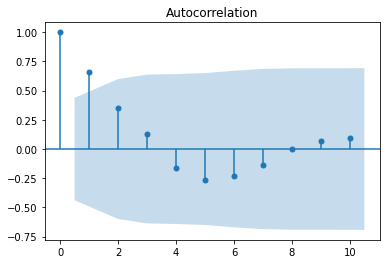

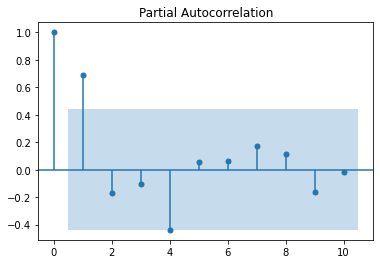

In [8]:
# Calculate stationary series from dataset
gold_nov_stationary_series = get_stationary_series(gold_nov_df)

# Plot the charts
plot_acf(gold_nov_stationary_series, lags = 10)
plot_pacf(gold_nov_stationary_series, lags = 10)
gold_nov_stationary_series

In [9]:
auto_arima(gold_nov_stationary_series, stationary=True, start_p=1, max_p = 10, 
           start_q = 1, max_q = 10, seasonal = False, trace= True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=62.873, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=77.573, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59.711, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=68.747, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=256.015, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=65.749, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=63.467, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.365 seconds


ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

<div class="alert alert-block alert-success">

<b>Interpretation of results / ARMA Model Justification:</b><br/>
We specified a range from 1 to 10 for each of the "p" and "q" variables of our ARMA model n the grid search above. We have set the seasonality to "False," since we are using less than a month of price data for model fitting, also since we made the data stationary, the parameter "stationary" is set to "True." The best fitting model, without overfitting the data" was ARMA(1, 0) according to AIC.
<br/>
</div>

In [10]:
ARMA_gld_nov = ARMA(gold_nov_stationary_series, order = (1, 0)).fit()
ARMA_gld_nov.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                   20
Model:                     ARMA(1, 0)   Log Likelihood                 -26.648
Method:                       css-mle   S.D. of innovations              0.881
Date:                Tue, 28 Sep 2021   AIC                             59.296
Time:                        03:30:38   BIC                             62.283
Sample:                             0   HQIC                            59.879
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             139.3191      1.438     96.897      0.000     136.501     142.137
ar.L1.Adj Close     0.8936      0.105      8.498      0.000       0.688       1.100
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1190           +0.0000j            1.1190            0.0000
-----------------------------------------------------------------------------
"""

<b>6.3) Using the October equity ETF prices, run an ARMA model with your choice of parameters.</b>

The series is not stationary.
We have done 4 iterations of differentiations.


Date
2019-10-07    1.132050
2019-10-08    0.264130
2019-10-09    1.726368
2019-10-10   -2.509354
2019-10-11    1.528244
2019-10-14   -2.452747
2019-10-15    3.981014
2019-10-16   -3.528206
2019-10-17    2.188633
2019-10-18   -1.132072
2019-10-21    0.735855
2019-10-22   -0.999977
2019-10-23    1.603710
2019-10-24   -1.660297
2019-10-25    0.716927
2019-10-28    0.386803
2019-10-29   -1.018848
2019-10-30    1.282986
2019-10-31   -1.471649
Name: Adj Close, dtype: float64

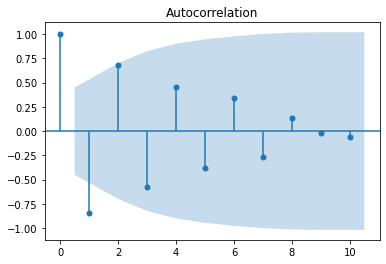

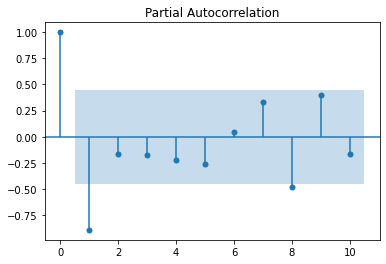

In [11]:
# Calculate stationary series from dataset
eq_oct_stationary_series = get_stationary_series(eq_oct_df)

# Plot the charts
plot_acf(eq_oct_stationary_series, lags = 10)
plot_pacf(eq_oct_stationary_series, lags = 10)
eq_oct_stationary_series

In [12]:
auto_arima(eq_oct_stationary_series, stationary=True, start_p=1, max_p = 10, 
           start_q = 1, max_q = 10, seasonal = False, trace= True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=81.492, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=58.179, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=79.501, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=59.388, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=56.370, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=57.621, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.402 seconds


ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

<div class="alert alert-block alert-success">

<b>Interpretation of results / ARMA Model Justification:</b><br/>
We specified a range from 1 to 10 for each of the "p" and "q" variables of our ARMA model n the grid search above. We have set the seasonality to "False," since we are using less than a month of price data for model fitting, also since we made the data stationary, the parameter "stationary" is set to "True." The best fitting model, without overfitting the data" was ARMA(1, 0) according to AIC.
<br/>
</div>

In [13]:
ARMA_eq_oct = ARMA(eq_oct_stationary_series, order = (1, 0)).fit()
ARMA_eq_oct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                   19
Model:                     ARMA(1, 0)   Log Likelihood                 -26.089
Method:                       css-mle   S.D. of innovations              0.923
Date:                Tue, 28 Sep 2021   AIC                             58.179
Time:                        03:30:38   BIC                             61.012
Sample:                    10-07-2019   HQIC                            58.658
                         - 10-31-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0514      0.117      0.438      0.661      -0.179       0.281
ar.L1.Adj Close    -0.8508      0.103     -8.273      0.000      -1.052      -0.649
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1754           +0.0000j            1.1754            0.5000
-----------------------------------------------------------------------------
"""

<b>6.4) Using the November equity ETF prices, run an ARMA model with your choice of parameters.</b>

The series is not stationary.
We have done 2 iterations of differentiations.


Date
2019-11-05   -0.377338
2019-11-06    0.084892
2019-11-07    0.141506
2019-11-08   -0.169804
2019-11-11    0.047165
2019-11-12   -0.028290
2019-11-13   -0.056610
2019-11-14    0.056602
2019-11-15    0.367905
2019-11-18   -0.245262
2019-11-19   -0.169815
2019-11-20   -0.254692
2019-11-21    0.273563
2019-11-22    0.150932
2019-11-25    0.349060
2019-11-26   -0.367920
2019-11-27    0.028294
2019-11-29   -0.415073
Name: Adj Close, dtype: float64

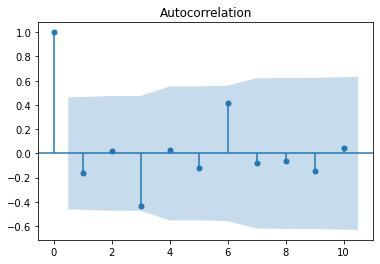

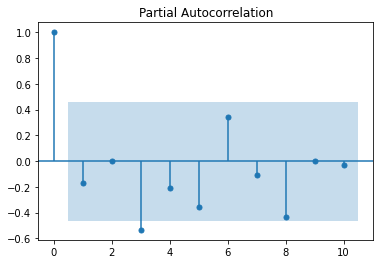

In [14]:
# Calculate stationary series from dataset
eq_nov_stationary_series = get_stationary_series(eq_nov_df)

# Plot the charts
plot_acf(eq_nov_stationary_series, lags = 10)
plot_pacf(eq_nov_stationary_series, lags = 10)
eq_nov_stationary_series

In [15]:
auto_arima(eq_nov_stationary_series, stationary=True, start_p=1, max_p = 10, 
           start_q = 1, max_q = 10, seasonal = False, trace= True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5.042, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3.163, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4.554, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1.500, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.123 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

<div class="alert alert-block alert-success">

<b>Interpretation of results / ARMA Model Justification:</b><br/>
We specified a range from 1 to 10 for each of the "p" and "q" variables of our ARMA model n the grid search above. We have set the seasonality to "False," since we are using less than a month of price data for model fitting, also since we made the data stationary, the parameter "stationary" is set to "True." The best fitting model, without overfitting the data" was ARMA(0, 0) according to AIC.

Since the best order is (0, 0), we identify that the choice of ARMA model might not be appropriate. Nonetheless, for demonstration purposes we chose to nonetheless fit an ARMA model for this part.
<br/>
</div>

In [16]:
ARMA_eq_nov = ARMA(eq_nov_stationary_series, order = (0, 0)).fit()
ARMA_eq_nov.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                   18
Model:                     ARMA(0, 0)   Log Likelihood                   0.419
Method:                           css   S.D. of innovations              0.236
Date:                Tue, 28 Sep 2021   AIC                              3.163
Time:                        03:30:39   BIC                              4.944
Sample:                             0   HQIC                             3.408
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0325      0.056     -0.583      0.560      -0.142       0.077
==============================================================================
"""

<div class="alert alert-block alert-success">
<b>6.5) What are the significant changes, if any?  Be specific with regards to the values of the parameters:</b> 

To summarise, the ARMA model results corroborates with the standard deviation values seen in earlier sections. Because the Gold prices in October and Equity prices in November were highly volatile and non-stationary, the best parameters found for the ARMA model were (0, 0). While for gold prices in November and equity prices in October, we were able to find the optimal ARMA parameters of (1,0), which is rather consistent across both models.
</div>    